In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df =  pd.read_csv('C:/Users/farha/Desktop/uni stage 3/Introduction to AI/COURSEWORK/Github/intro-to-ai-farhan-labi/covid_19_indonesia_time_series_all.csv')

In [4]:
df_regression = df.copy()

In [5]:
#Set date as index
df_regression = df_regression.set_index('Date')

In [6]:
#For the NA values that are in int columns, fill them with medians 
med_gf_nc = df_regression['Growth Factor of New Cases'].median()
med_gf_nd = df_regression['Growth Factor of New Deaths'].median()
med_tot_uv = df_regression['Total Urban Villages'].median()
med_tot_rv = df_regression['Total Rural Villages'].median()
med_tot_c = df_regression['Total Cities'].median()

df_regression['Growth Factor of New Cases'] = df_regression['Growth Factor of New Cases'].fillna(med_gf_nc)

df_regression['Growth Factor of New Deaths'] = df_regression['Growth Factor of New Deaths'].fillna(med_gf_nd)

df_regression['Total Urban Villages'] = df_regression['Total Urban Villages'].fillna(med_tot_uv)

df_regression['Total Rural Villages'] = df_regression['Total Rural Villages'].fillna(med_tot_rv)

df_regression['Total Cities'] = df_regression['Total Cities'].fillna(med_tot_c)

In [7]:
#We can drop the following columns, because either they are redundant, have nothing in them (all rows NA) or non relevant
df_regression = df_regression.drop(columns=['City or Regency', 'Province', 'Island', 'Time Zone', 'Special Status', 'Location ISO Code',
                                           'Location Level', 'Country', 'Continent', 'Location', 'Case Fatality Rate', 'Case Recovered Rate'])

In [8]:
#Check datatypes of all remaining columns in dataframe
print(df_regression.dtypes)

New Cases                        int64
New Deaths                       int64
New Recovered                    int64
New Active Cases                 int64
Total Cases                      int64
Total Deaths                     int64
Total Recovered                  int64
Total Active Cases               int64
Total Regencies                  int64
Total Cities                   float64
Total Districts                  int64
Total Urban Villages           float64
Total Rural Villages           float64
Area (km2)                       int64
Population                       int64
Population Density             float64
Longitude                      float64
Latitude                       float64
New Cases per Million          float64
Total Cases per Million        float64
New Deaths per Million         float64
Total Deaths per Million       float64
Total Deaths per 100rb         float64
Growth Factor of New Cases     float64
Growth Factor of New Deaths    float64
dtype: object


In [9]:
#Convert all columns to float32 unless it is float64 (for regression)
#It is already float 64
df_regression[['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases',
              'Total Deaths', 'Total Recovered', 'Total Active Cases',
              'Total Regencies', 'Total Districts', 'Area (km2)', 'Population']] = df_regression[['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases',
              'Total Deaths', 'Total Recovered', 'Total Active Cases',
              'Total Regencies', 'Total Districts', 'Area (km2)', 'Population']].astype('float32') 

In [10]:
#Remove outliers function
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) 
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [11]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

In [12]:
remove_outliers(df_regression, 'New Active Cases', 2)
X,y = to_xy(df_regression, 'New Active Cases')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [13]:
sc_x = StandardScaler()
sc_x.fit(X_train)
#Transform x
X_train= sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

In [14]:
model = Sequential()
model.add(Dense(1024, input_shape=X[1].shape, activation='relu')) # Hidden 1
model.add(Dense(64, activation='relu')) #Hidden 2
model.add(Dense(1)) # Output

In [15]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=20)
model.summary()

Epoch 1/20
372/372 - 0s - loss: 25110.0801
Epoch 2/20
372/372 - 0s - loss: 21461.1016
Epoch 3/20
372/372 - 0s - loss: 15771.9648
Epoch 4/20
372/372 - 0s - loss: 11803.0312
Epoch 5/20
372/372 - 0s - loss: 6706.5928
Epoch 6/20
372/372 - 0s - loss: 2613.0049
Epoch 7/20
372/372 - 0s - loss: 1682.6207
Epoch 8/20
372/372 - 0s - loss: 1453.0803
Epoch 9/20
372/372 - 0s - loss: 1726.3743
Epoch 10/20
372/372 - 0s - loss: 750.4084
Epoch 11/20
372/372 - 0s - loss: 676.6595
Epoch 12/20
372/372 - 0s - loss: 361.2345
Epoch 13/20
372/372 - 0s - loss: 170.7484
Epoch 14/20
372/372 - 0s - loss: 211.1099
Epoch 15/20
372/372 - 0s - loss: 271.0270
Epoch 16/20
372/372 - 0s - loss: 369.4234
Epoch 17/20
372/372 - 0s - loss: 1871.5585
Epoch 18/20
372/372 - 0s - loss: 267.6543
Epoch 19/20
372/372 - 0s - loss: 536.7183
Epoch 20/20
372/372 - 0s - loss: 691.2974
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

In [16]:
y_pred = model.predict(X_test)
print("Shape: {}".format(y_pred.shape))
print("Shape: {}".format(y_test.shape))

Shape: (3961, 1)
Shape: (3961, 1)


In [17]:
print("final RMSE =", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

final RMSE = 24.854122


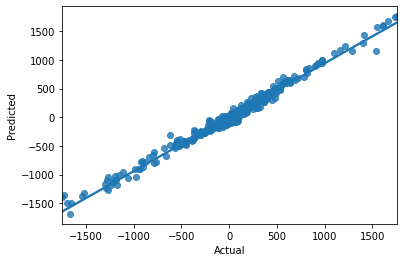

In [18]:
#Plot model of predicted vs actual with seaborn
df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
sns.regplot(x='Actual', y='Predicted', data=df_compare);

In [19]:
#Past this point is debug area

In [20]:
#Check type of x,y for debug
print(X_test.dtype)
print(X_train.dtype)
print(y_train.dtype)
print(y_test.dtype)

float32
float32
float32
float32


In [21]:
#Debug
print(y_test)
print(y_pred)

[[  -1.]
 [ -18.]
 [-148.]
 ...
 [   4.]
 [ -45.]
 [   2.]]
[[   5.5519953]
 [ -23.009624 ]
 [-145.8136   ]
 ...
 [   2.6117375]
 [ -45.336372 ]
 [  -1.0825136]]
